In [1]:
from IPython.display import clear_output

!wget -O event_log.xlsx https://www.dropbox.com/scl/fi/476pv9z4pdj53ju07ylmi/LivingLabHospital_Interpreted-Location-event-logs.xlsx?rlkey=iejek2prife6x4qrr0nckqtrq&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pd.read_excel('event_log.xlsx')

# Only keep rows with complete event information
event_log = event_log.head(2222)

log_format = {'case:concept:name': 'ID',
              'concept:name': 'Activity_MACRO',
              'time:timestamp': 'Timestamp end',
              'start_timestamp': 'Timestamp start',
              'org:resource': 'Ress. Humaines',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 328
Variant count: 95
Event count: 2222
Activity count: 36


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 14.723068 seconds.


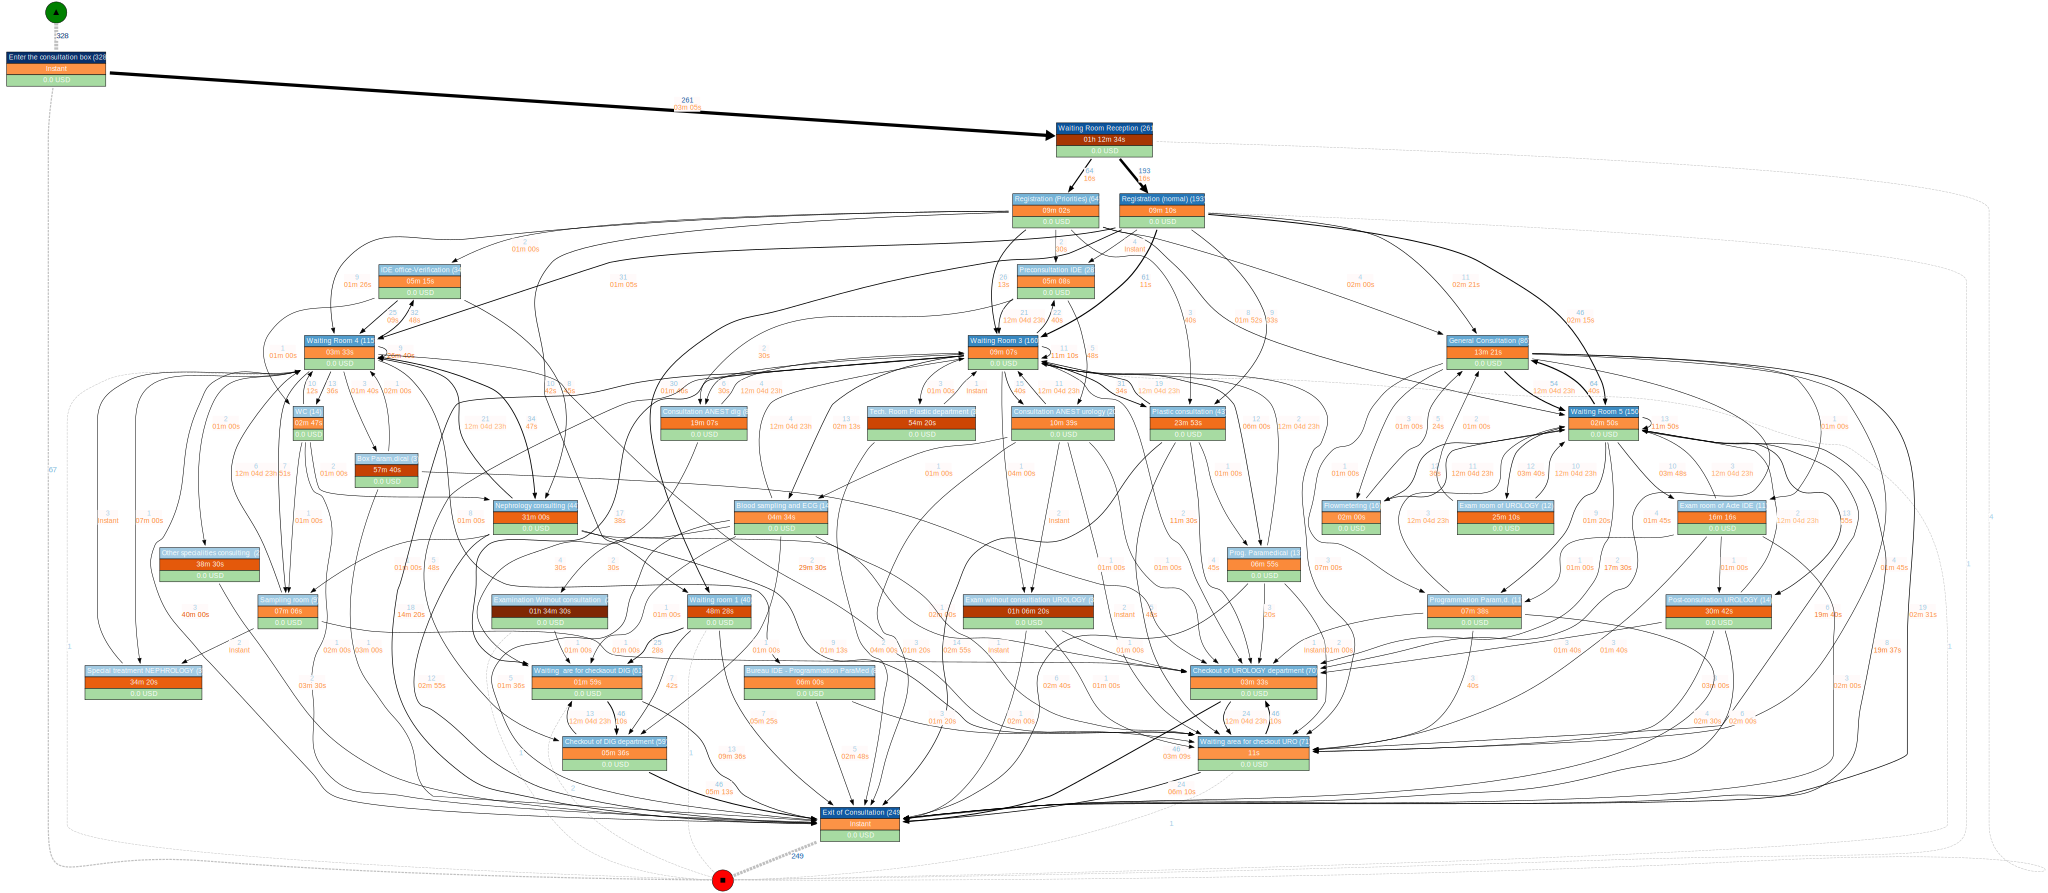

MP-DFG visualization time: 0.384475 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 328/328 [00:02<00:00, 149.13it/s]


Calculating log metrics: 


100%|██████████| 328/328 [00:04<00:00, 69.86it/s]


Building Tree Cases:


100%|██████████| 328/328 [00:11<00:00, 29.78it/s]


Building Tree Graph:


100%|██████████| 328/328 [00:00<00:00, 3042.15it/s]


MD-DRT discovery time: 18.120318 seconds.


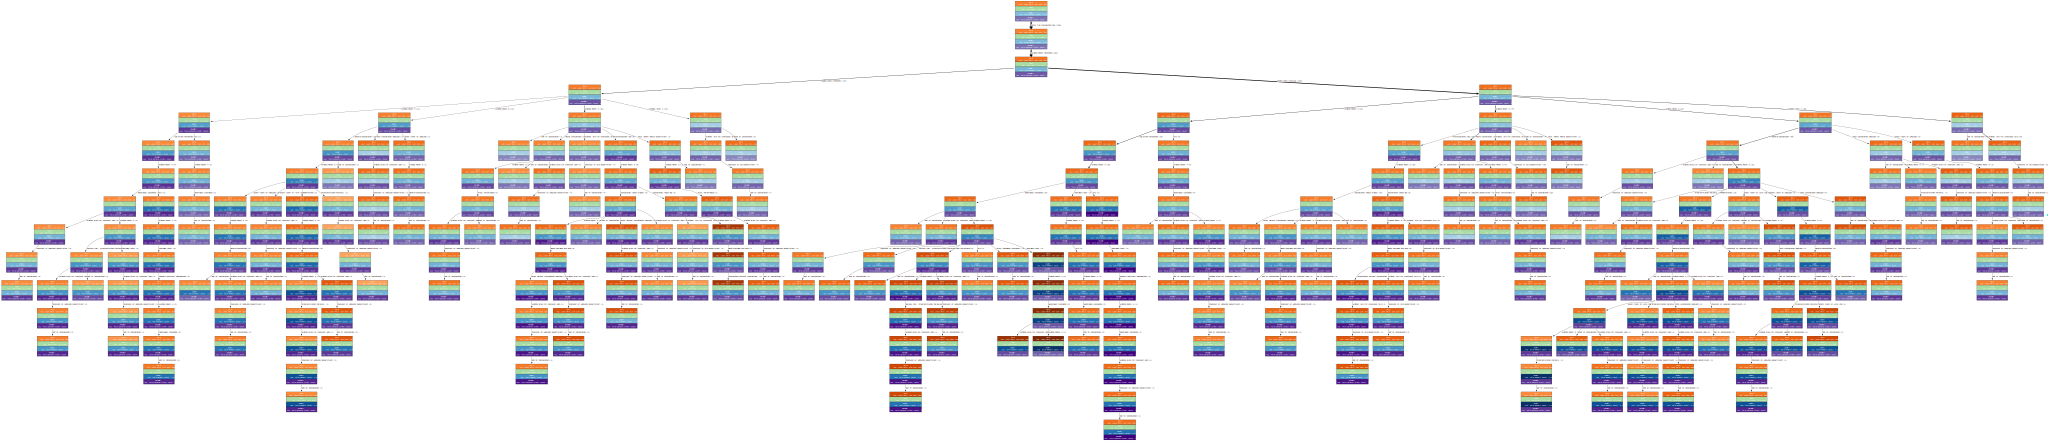

MD-DRT visualization time: 0.943904 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 14.723068 seconds.
MP-DFG visualization time: 0.384475 seconds.
MD-DRT discovery time: 18.120318 seconds.
MD-DRT visualization time: 0.943904 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The original log contains several cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that end with 'Exit of Consultation' will be considered
processed_log = pm4py.filter_end_activities(processed_log, ['Exit of Consultation'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 328
Case count after: 249


In [13]:
# The activities of the original log refer to similar activities with different names (e.g., different exams and consultations in the same department)
# To reduce the number of activities, similar activities are renamed to a unique name
processed_log['concept:name'] = processed_log['concept:name'].copy().apply(lambda x : 'Consultation UROLOGY' if (x == 'Post-consultation UROLOGY') or (x == 'General Consultation') or (x == 'Consultation ANEST urology') or (x == 'Plastic consultation') else x)
processed_log['concept:name'] = processed_log['concept:name'].copy().apply(lambda x : 'Exams UROLOGY' if (x == 'Exam room of Acte IDE') or (x == 'Exam room of UROLOGY') or (x == 'Flowmetering') or (x == 'Exam without consultiation UROLOGY') else x)
processed_log['concept:name'] = processed_log['concept:name'].copy().apply(lambda x : 'Paramedical Programming' if ('Programmation Param‚d' in x) or (x == 'Prog. Paramedical') or (x == 'Bureau IDE - Programmation ParaMed') else x)

# Moreover, some activities can be grouped as they always directly follow each other
# This also allows observing the actual time spent in the reception waiting room for priority and normal registrations
processed_log = mpvis.preprocessing.manual_log_grouping(processed_log, activities_to_group = ['Checkout of UROLOGY department', 'Waiting area for checkout URO'], group_name = 'Checkout of UROLOGY Department')
processed_log = mpvis.preprocessing.manual_log_grouping(processed_log, activities_to_group = ['Checkout of DIG department', 'Waiting  are for checkaout DIG'], group_name = 'Checkout of DIG Department')
processed_log = mpvis.preprocessing.manual_log_grouping(processed_log, activities_to_group = ['Registration (Priorities)', 'Waiting Room Reception'], group_name = 'Registration (Priorities)')
processed_log = mpvis.preprocessing.manual_log_grouping(processed_log, activities_to_group = ['Registration (normal)', 'Waiting Room Reception'], group_name = 'Registration (Normal)')

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return fn(*args, **kwargs)


Manual log grouping:


100%|██████████| 249/249 [00:02<00:00, 92.69it/s]


Manual log grouping:


100%|██████████| 249/249 [00:01<00:00, 124.60it/s]


Manual log grouping:


100%|██████████| 249/249 [00:02<00:00, 109.04it/s]


Manual log grouping:


100%|██████████| 249/249 [00:04<00:00, 51.30it/s]


Activity count before: 36
Activity count after: 25


In [14]:
previous_case = None
for index, row in processed_log.iterrows():
  if 'Registration' in row['concept:name']:
    if (previous_case is not None) and row['case:concept:name'] == previous_case['case:concept:name']:
      print(previous_case['case:concept:name'] + ' - ' + previous_case['concept:name'])
      print(row['case:concept:name'] + ' - ' + row['concept:name'])
    previous_case = row

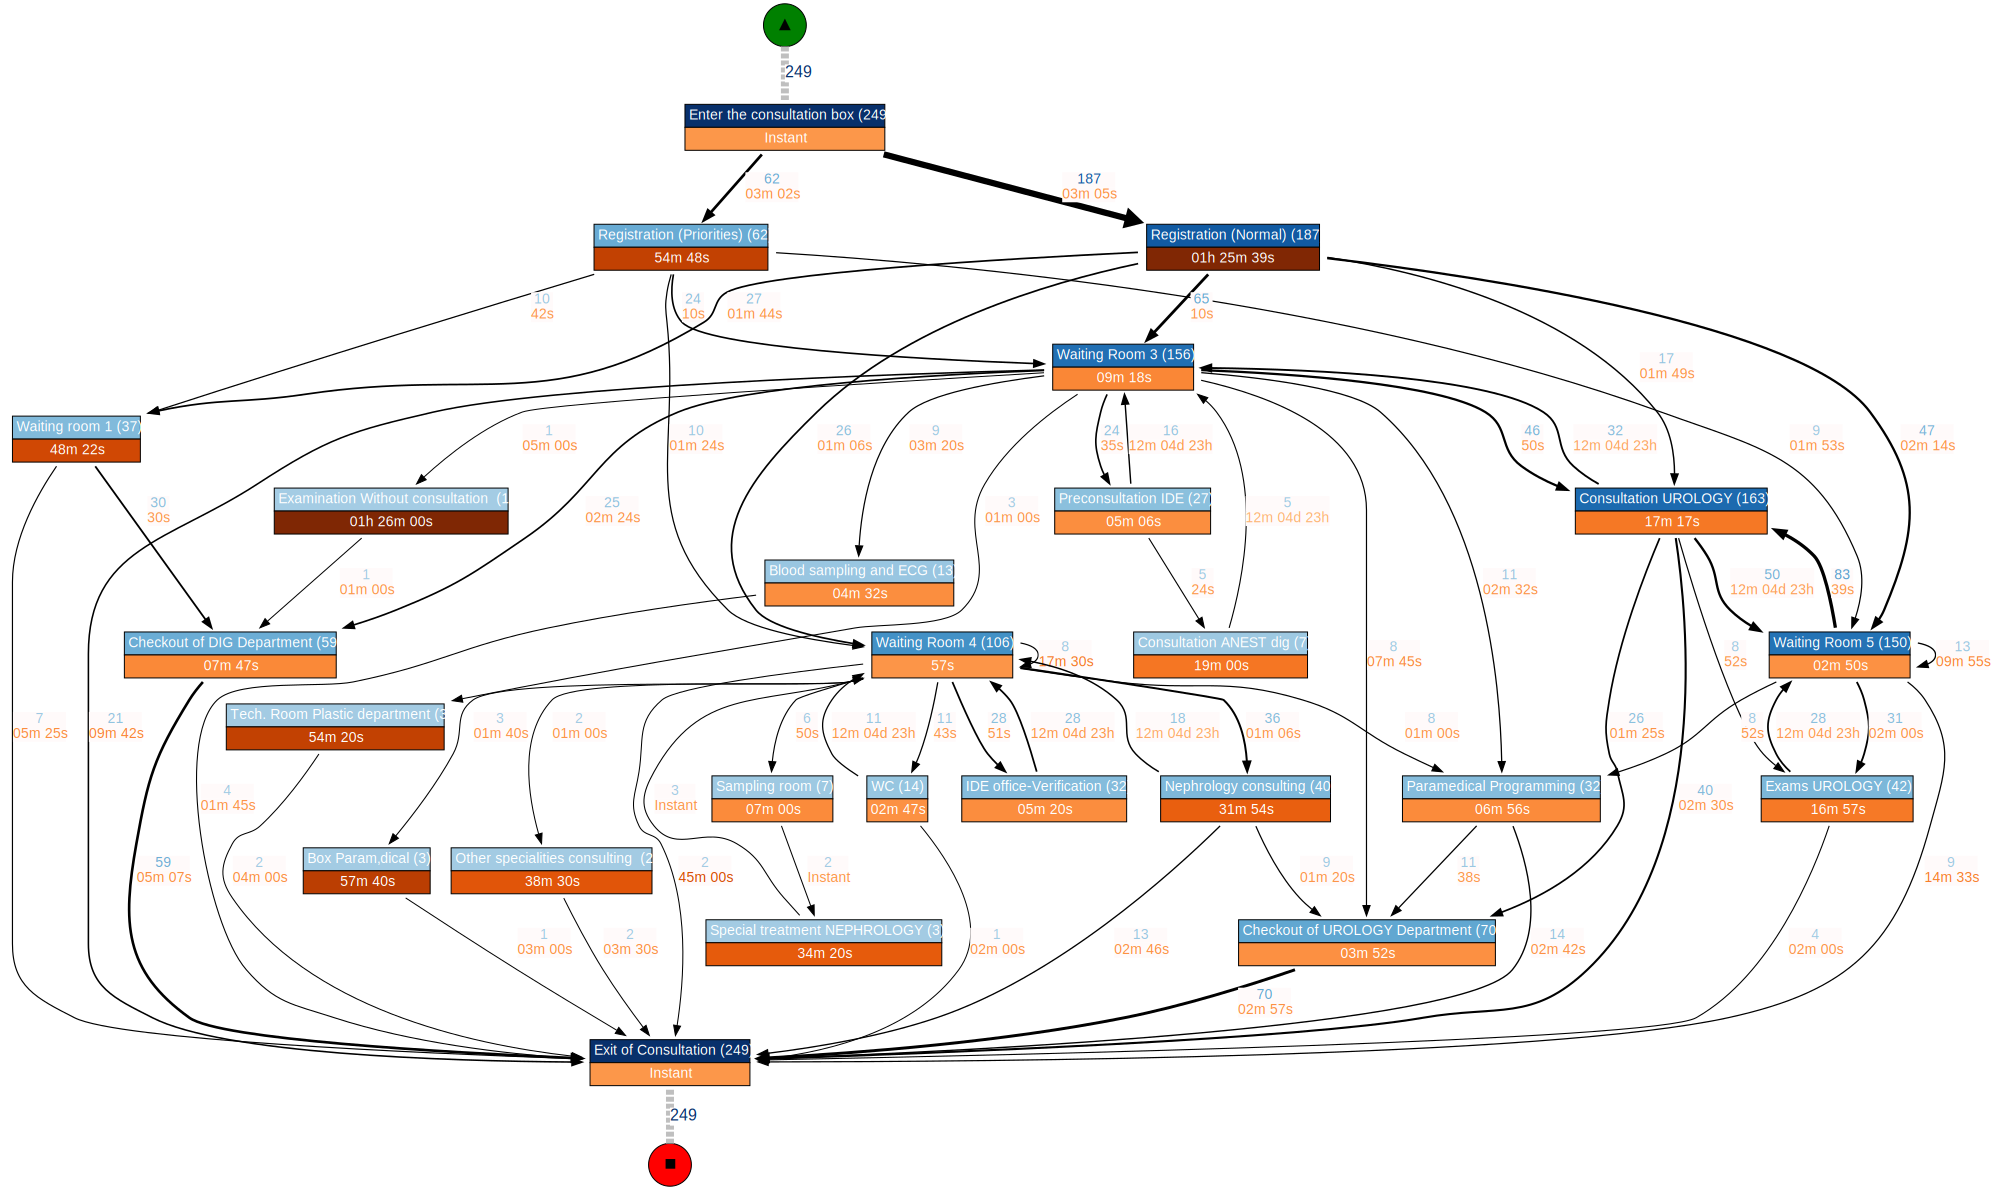

In [15]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

# While it is of interest to see all the activities, uncommon paths can be filtered
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(40, dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_40', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_40.svg'))

In [16]:
# It is also observed that visualizing separate DFGs for every Waiting room would allow additional insights
waiting_room_1_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Waiting room 1'], level = 'case')
waiting_room_3_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Waiting Room 3'], level = 'case')
waiting_room_4_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Waiting Room 4'], level = 'case')
waiting_room_5_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Waiting Room 5'], level = 'case')

print("Case count of the processed log: " + str(len(set(processed_log['case:concept:name']))))
print("Case count of the log for waiting room 1: " + str(len(set(waiting_room_1_log['case:concept:name']))))
print("Case count of the log for waiting room 3: " + str(len(set(waiting_room_3_log['case:concept:name']))))
print("Case count of the log for waiting room 4: " + str(len(set(waiting_room_4_log['case:concept:name']))))
print("Case count of the log for waiting room 5: " + str(len(set(waiting_room_5_log['case:concept:name']))))

Case count of the processed log: 249
Case count of the log for waiting room 1: 37
Case count of the log for waiting room 3: 103
Case count of the log for waiting room 4: 40
Case count of the log for waiting room 5: 69


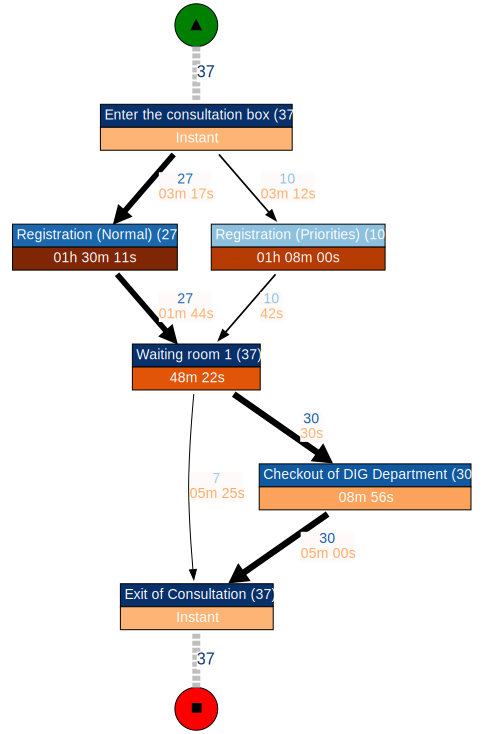

In [17]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(waiting_room_1_log.copy())
mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_waiting_room_1_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_waiting_room_1_100_100.svg'))

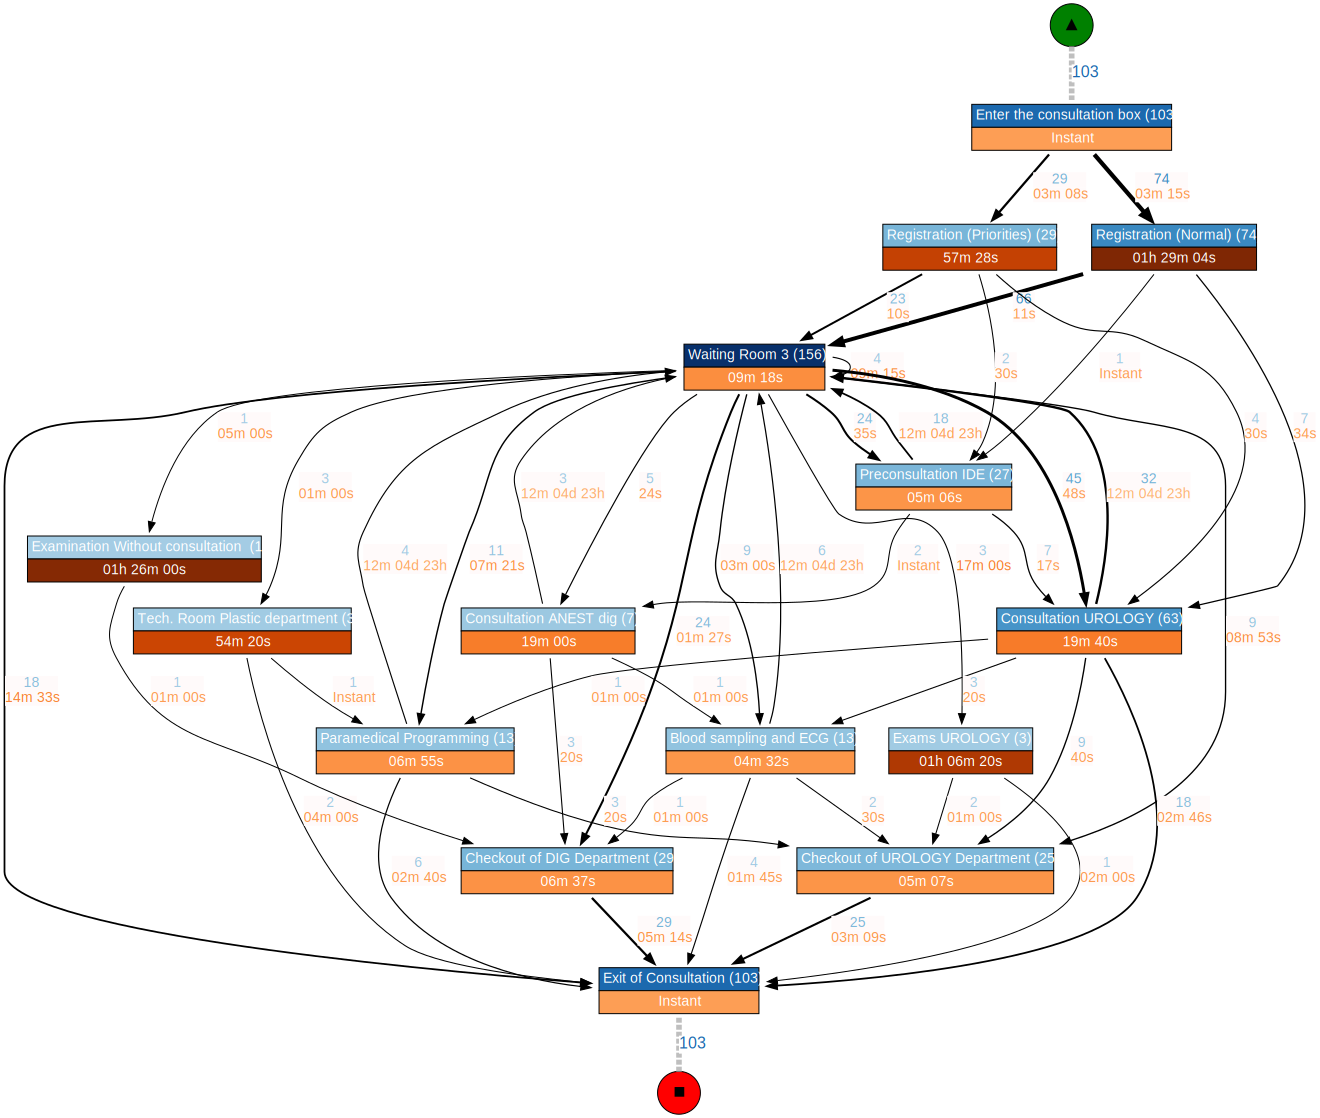

In [18]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(waiting_room_3_log.copy())
mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_waiting_room_3_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_waiting_room_3_100_100.svg'))

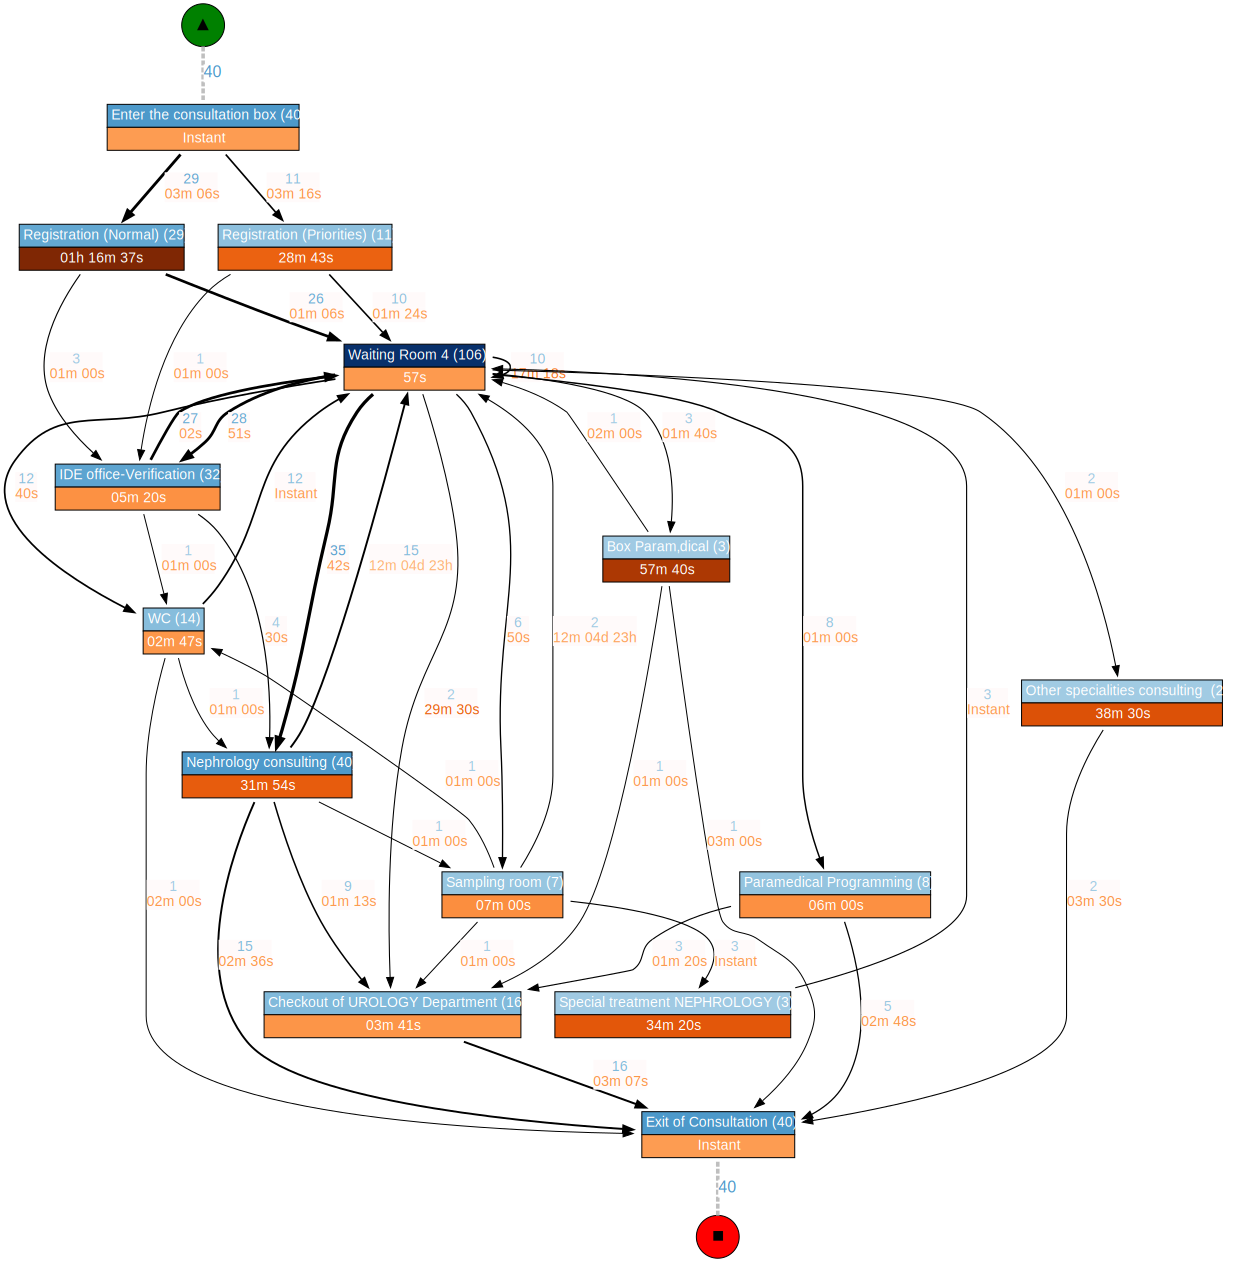

In [19]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(waiting_room_4_log.copy())
mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_waiting_room_4_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_waiting_room_4_100_100.svg'))

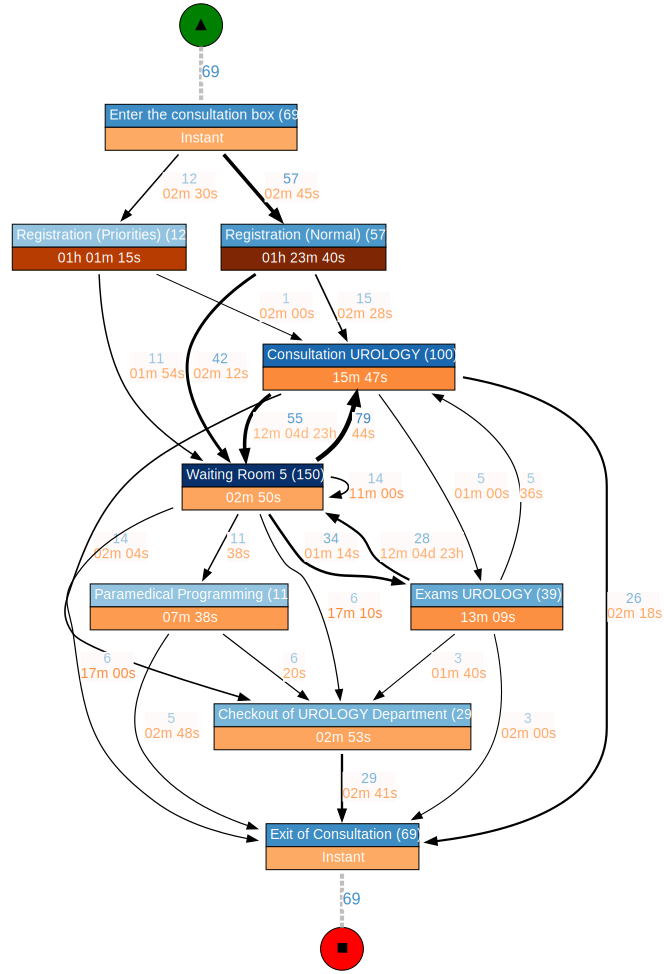

In [20]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(waiting_room_5_log.copy())
mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_waiting_room_5_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_waiting_room_5_100_100.svg'))

Calculating log mandatory activities: 


100%|██████████| 249/249 [00:01<00:00, 166.27it/s]


Calculating log metrics: 


100%|██████████| 249/249 [00:02<00:00, 102.80it/s]


Building Tree Cases:


100%|██████████| 249/249 [00:09<00:00, 26.86it/s]


Building Tree Graph:


100%|██████████| 249/249 [00:00<00:00, 6283.43it/s]


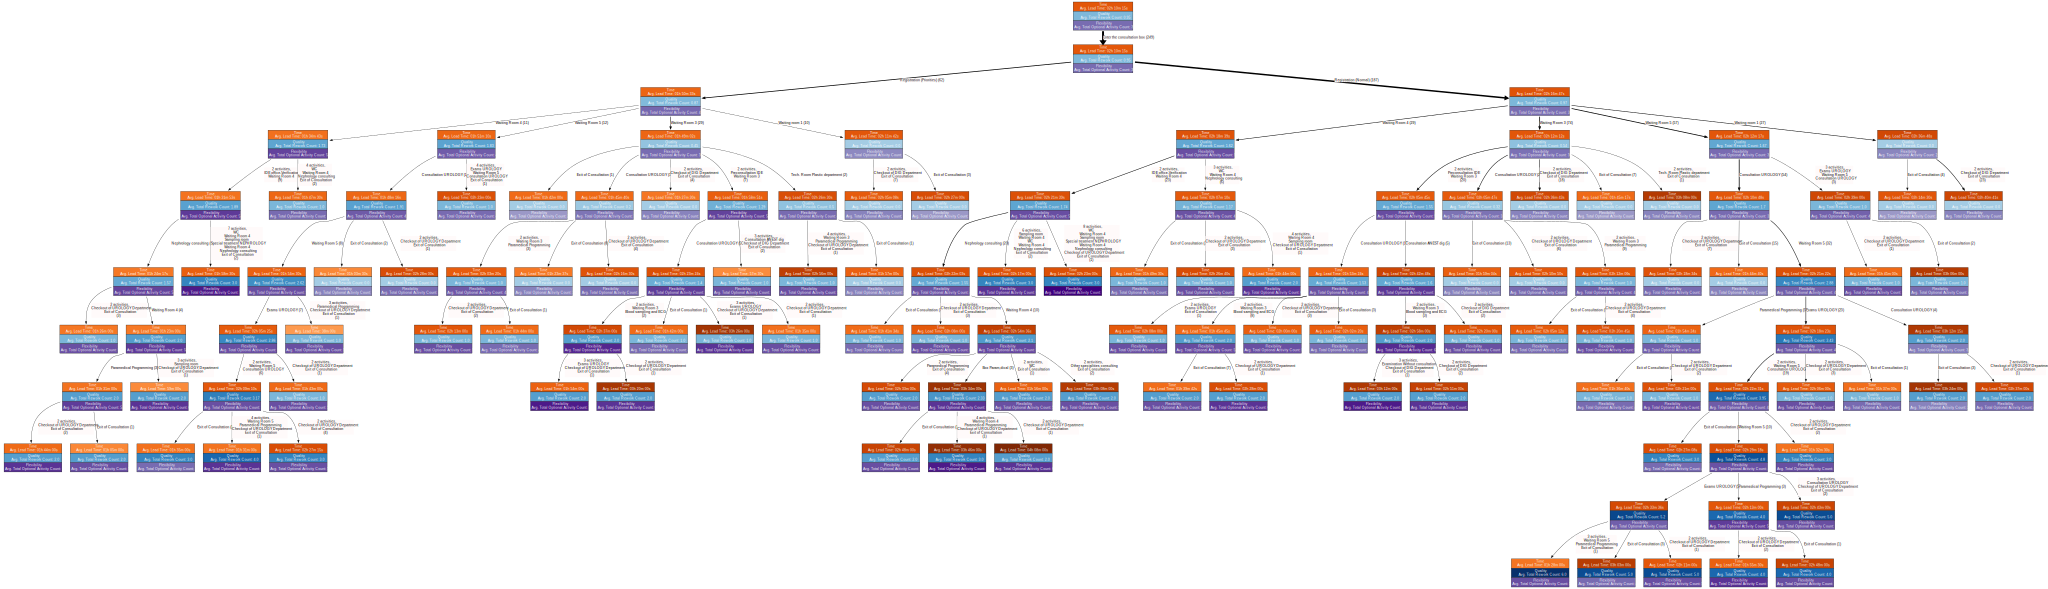

In [21]:
# Similarly, the process followed in every waiting room can more easily be observed through a DRT
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup.svg'))

In [22]:
# It is also possible to visualize separate DRTs for normal and priority registrations
normal_registrations_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Registration (Normal)'], level = 'case')
priority_registrations_log = pm4py.filter_event_attribute_values(processed_log.copy(), 'concept:name', ['Registration (Priorities)'], level = 'case')

print("Case count of the processed log: " + str(len(set(processed_log['case:concept:name']))))
print("Case count of the log for normal registrations: " + str(len(set(normal_registrations_log['case:concept:name']))))
print("Case count of the log for priority registrations: " + str(len(set(priority_registrations_log['case:concept:name']))))

Case count of the processed log: 249
Case count of the log for normal registrations: 187
Case count of the log for priority registrations: 62


Calculating log mandatory activities: 


100%|██████████| 187/187 [00:01<00:00, 182.09it/s]


Calculating log metrics: 


100%|██████████| 187/187 [00:01<00:00, 112.13it/s]


Building Tree Cases:


100%|██████████| 187/187 [00:06<00:00, 30.39it/s]


Building Tree Graph:


100%|██████████| 187/187 [00:00<00:00, 3940.75it/s]


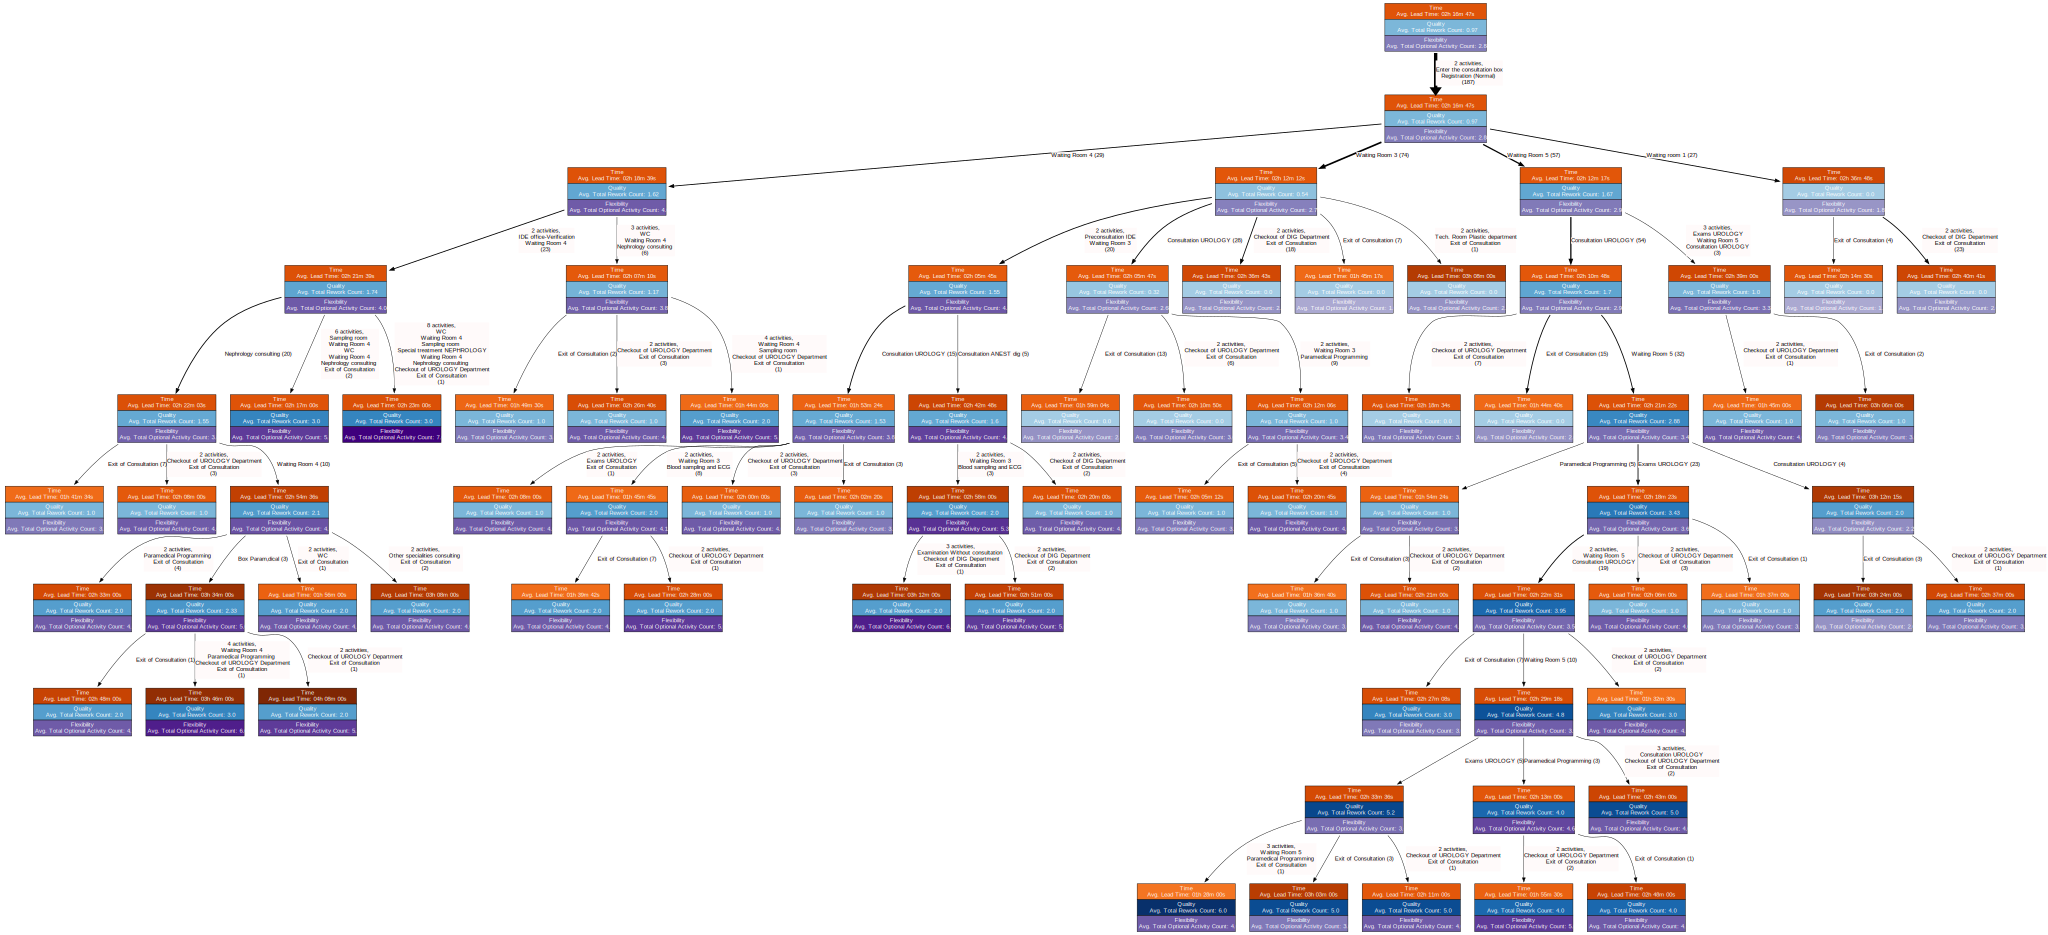

In [23]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(normal_registrations_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_normal_registrations_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_normal_registrations_log_autogroup.svg'))

Calculating log mandatory activities: 


100%|██████████| 62/62 [00:00<00:00, 155.66it/s]


Calculating log metrics: 


100%|██████████| 62/62 [00:00<00:00, 85.75it/s]


Building Tree Cases:


100%|██████████| 62/62 [00:02<00:00, 22.33it/s]


Building Tree Graph:


100%|██████████| 62/62 [00:00<00:00, 5460.07it/s]


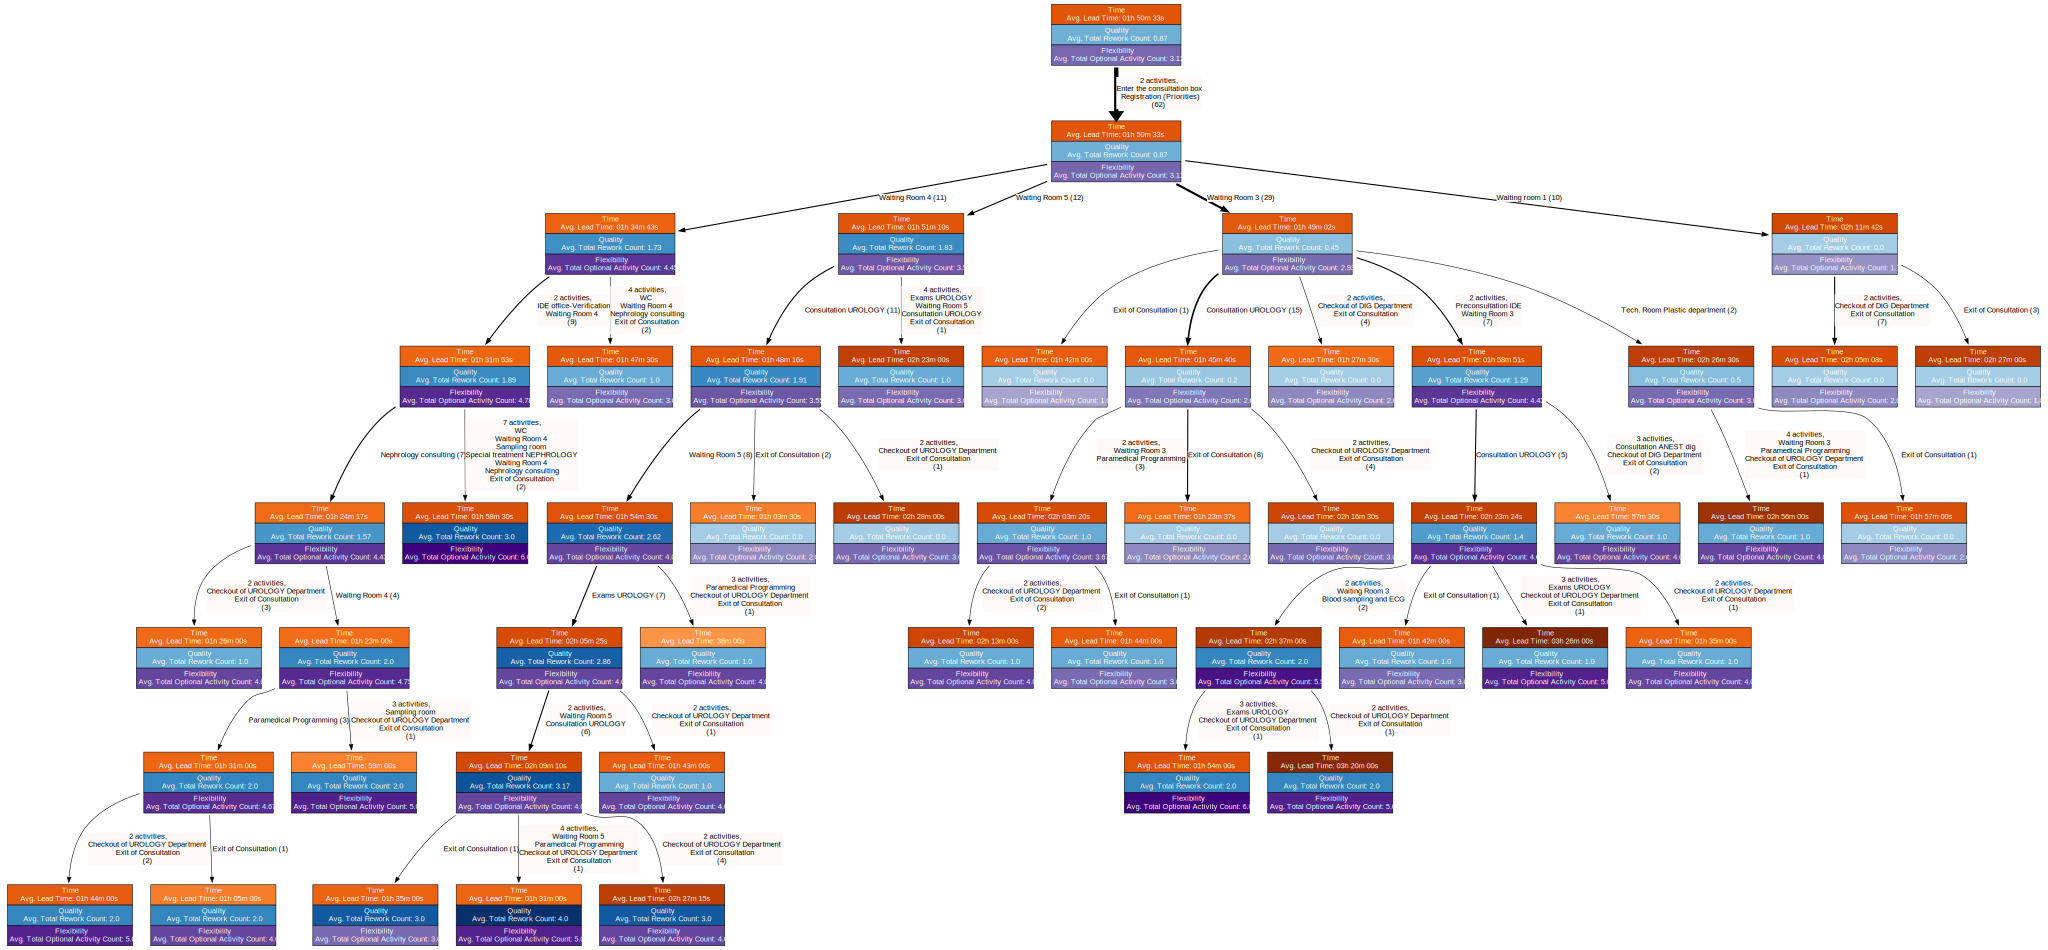

In [24]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(priority_registrations_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_priority_registrations_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_priority_registrations_log_autogroup.svg'))